<a href="https://colab.research.google.com/github/rrrajjjj/Gloria-Flood-Analysis/blob/main/Earth_Observation_Data_Scientist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### The following area inside Maresme County along the Tordera river has been selected for the analysis. 

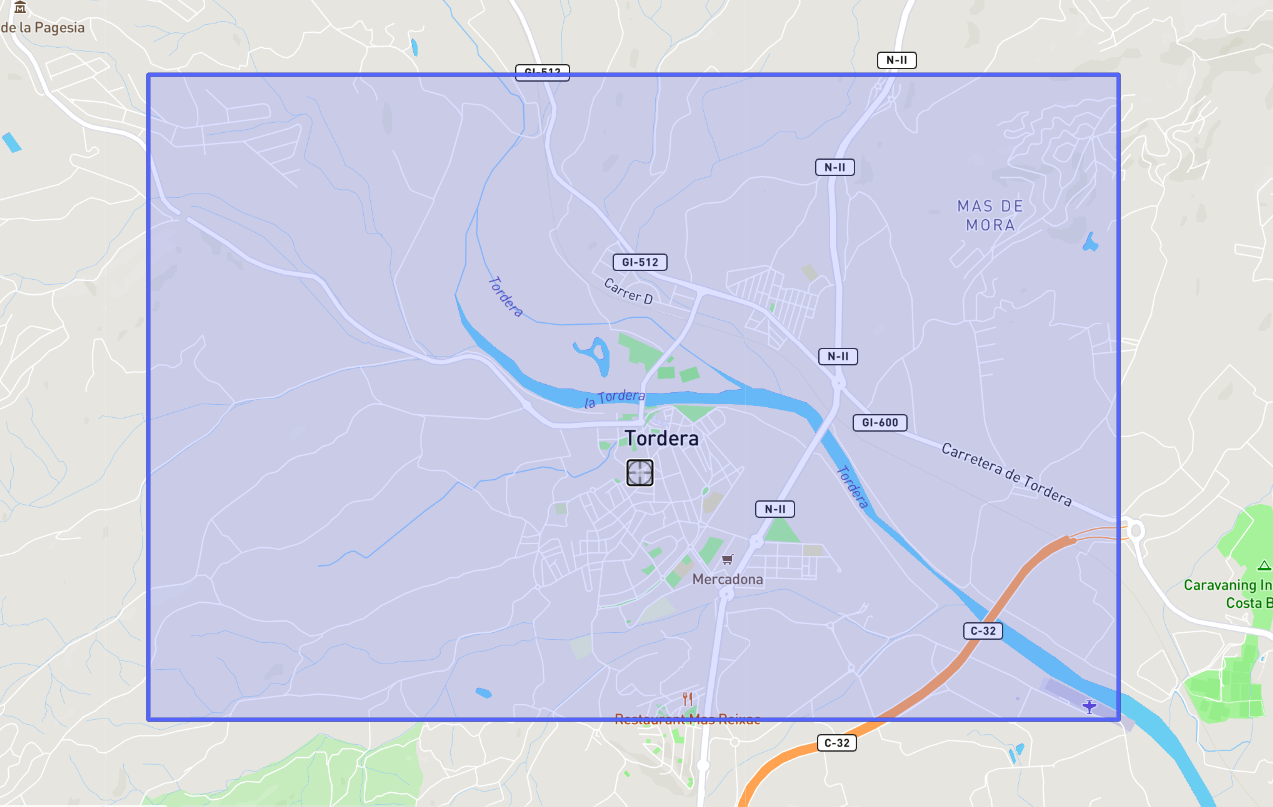

### Install Sentinel Hub

In [ ]:
!pip install sentinelhub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 211 kB 7.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 131 kB 42.0 MB/s 
     |████████████████████████████████| 6.3 MB 54.7 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 48 kB 6.2 MB/s 
  Created wheel for sentinelhub: filename=sentinelhub-3.6.3-py3-none-any.whl size=232235 sha256=7e95a00fcaca7dae6ab6d194da0f92828ea1472fd138d80242c30fc8bff1ffaf
  Stored in directory: /root/.cache/pip/wheels/37/fc/38/c1fbbd7dc8efdf4ee84075edb4baf7a92a2e21d2c2039a0cf7
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6108 sha256=f32f12247153e3078f464eb39ad3941d80dbcbc9239698ced60aa5d5bcdc894f
  Stored in directory: /root/.cache/pip/wheels/a5/b0/12/7ee4fdb0f9fbb4157100bd0

### Set up Sentinel Hub Credentials

In [ ]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = "9932fb8f-ce45-4b2b-a262-5885fd2129b7"
config.sh_client_secret = "d0}-PG8Ft,)GrO8HwoAId5r1H%CuVfpy.}AYyi(b"

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")


In [ ]:
# Import Libraries
import datetime
import os

from typing import Any, Optional, Tuple


import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

### Housekeeping Functions

### Set Coordinates to Retrieve

In [ ]:
#@title Enter Bounding Box Coordinantes Here 
#@markdown Bounding box for region of interest can be found using the following website - http://bboxfinder.com/
bbox_coords = [2.68,41.68, 2.75, 41.71]  #@param


In [ ]:
resolution = 10
bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {size} pixels")


Image shape at 10 m resolution: (584, 331) pixels


### Fetch Images

Let's retrieve pre and post-flood images.

In [ ]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color_pre = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-01-1", "2020-01-10"),
            mosaicking_order=MosaickingOrder.LEAST_CC
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    size=size,
    config=config,
)

request_true_color_early = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-01-15", "2020-01-20"),
            mosaicking_order=MosaickingOrder.LEAST_CC
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    size=size,
    config=config,
)

request_true_color_late = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-01-20", "2020-01-25"),
            mosaicking_order=MosaickingOrder.LEAST_CC
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    size=size,
    config=config,
)

In [ ]:
true_color_imgs_pre = request_true_color_pre.get_data()
true_color_imgs_early = request_true_color_early.get_data()
true_color_imgs_late = request_true_color_late.get_data()

Image type: uint8


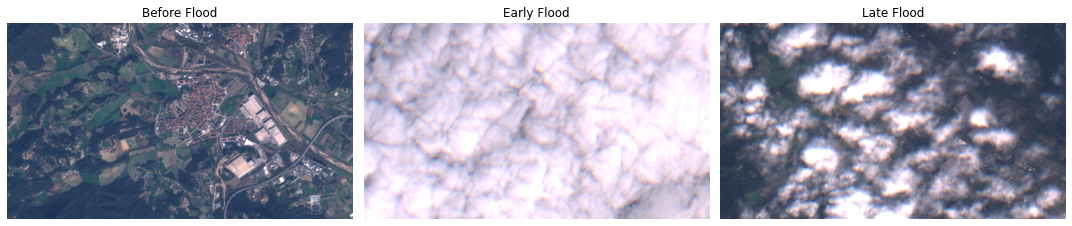

In [ ]:
image_pre_true = true_color_imgs_pre[0]
image_early_true = true_color_imgs_early[0]
image_late_true = true_color_imgs_late[0]

print(f"Image type: {image_pre_true.dtype}")

# display images
# factor 1/255 to scale between 0-1
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
ax[0].imshow(np.clip(image_pre_true * 3.5/255, 0, 1))
ax[0].set_title("Before Flood")
ax[1].imshow(np.clip(image_early_true * 2.5/255, 0, 1))
ax[1].set_title("Early Flood")
ax[2].imshow(np.clip(image_late_true * 2.5/255, 0, 1))
ax[2].set_title("Late Flood")
[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()


## Very Dense Cloud Cover!

It can be seen that the RGB channels would not be helpful in this case as there is very dense cloud cover during the time of interest. 
The clouds could be removed using mosaicking where patches of images over a span of multiple days would be stiched together such that the final mosaic has the least cloud coverage. But in our case, the clouds persist for the entire duration of the storm and mosaicking doesn't make the images any clearer. 

## NDWI Calculation for Water Body Detection 
NDWI - Normalized Difference Water Index

In the following publications, NDWI (or a modified version thereof) has been used to estimate flooded regions in sattelite imagery. 

*Pena-Regueiro, Jesus, et al. "Sentinel-2 analysis of flooded areas: applied case study-La safor wetland, Spain." WIT Transactions on Ecology and the Environment 242 (2020): 63-70.*

*Xu, H. "Modification of Normalised Difference Water Index (NDWI) to Enhance Open Water Features in Remotely Sensed Imagery." International Journal of Remote Sensing 27, No. 14 (2006): 3025-3033." (ESRI, 2018)*

Following that, an attempt has been made to calculate the NDWI values in the following cells. 

In [ ]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B02","B03","B04","B08","B12"],
            }],
            output: {
                bands: 5,
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02,
                sample.B03,
                sample.B04,
                sample.B08,
                sample.B12];
    }
"""

request_all_bands_pre = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-01-01", "2020-01-05"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config,
)

request_all_bands_post = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-01-20", "2020-01-25"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config,
)

all_bands_response_pre = request_all_bands_pre.get_data()
all_bands_response_post = request_all_bands_post.get_data()


In [ ]:
def calc_ndwi(all_bands):
  swir = all_bands[0][:, :, 4]
  green = all_bands[0][:, :, 1]
  ndwi = (green - swir)/(swir + green)
  return ndwi



In [ ]:
image_pre = all_bands_response_pre[0][:, :, :3]
image_post = all_bands_response_post[0][:, :, :3]
ndwi_pre = calc_ndwi(all_bands_response_pre)
ndwi_post = calc_ndwi(all_bands_response_post)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [ ]:
image_pre.max()

116

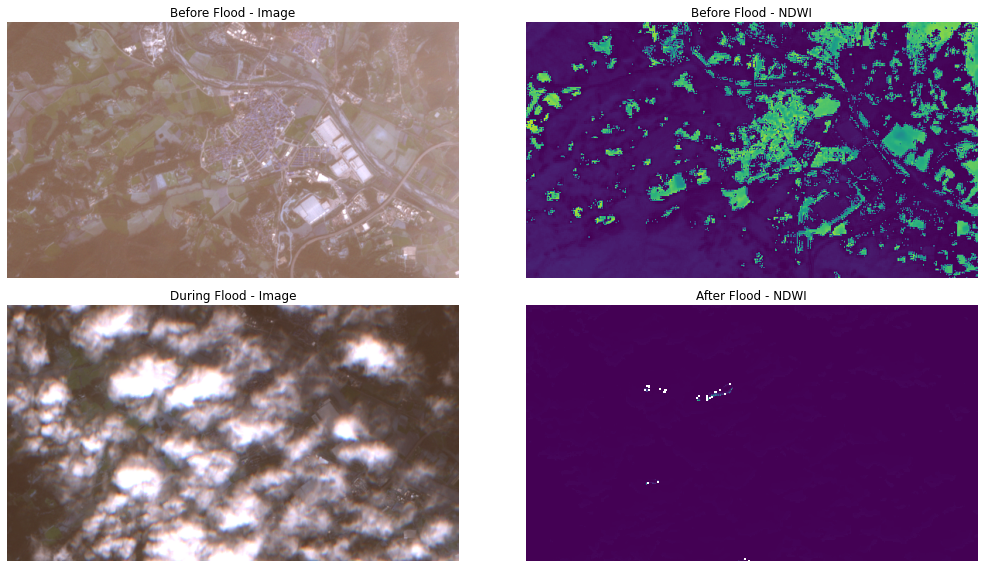

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (15, 8))
ax[0][0].imshow(np.clip(image_pre*3.5/255, 0, 1))
ax[0][0].set_title("Before Flood - Image")
ax[0][1].imshow(ndwi_pre)
ax[0][1].set_title("Before Flood - NDWI")
ax[1][0].imshow(np.clip(image_post*2.5/255 , 0, 1))
ax[1][0].set_title("During Flood - Image")
ax[1][1].imshow(ndwi_post)
ax[1][1].set_title("After Flood - NDWI")
[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()

Again, it can be observed that the cloud coverage poses a challenge. Since the green channel is used to calcualate the NWDI, and the clouds block access to the frequencies in the visible spectrum, reliable NDWI calculation is not possible.

## Sentinel-1 (SAR)

The solution here is to switch to Sentinel-1, which is a SAR data collection. Here we can effectively see through clouds and are not effected by lighting conditions as suggested in the following publications. 

*Paul, Sayak, and Siddha Ganju. "Flood Segmentation on Sentinel-1 SAR Imagery with Semi-Supervised Learning." arXiv preprint arXiv:2107.08369 (2021).*

*Tanim, Ahad Hasan, et al. "Flood Detection in Urban Areas Using Satellite Imagery and Machine Learning." Water 14.7 (2022): 1140.*

The unsupervised approach from the second paper has been followed in the notebook. 

## Methodology 
- **Step 1** - Get the VH band from Sentinel-1 SAR imagery for timepoints before and after the flooding
- **Step 2** - Calculate the change between the two conditions 
- **Step 3** - Calculate the Otsu-Threshold for the change map
- **Step 4** - Fuzzify the change map using the threshold and the spread of the distribution
- **Step 5** - Discretize the pixel-wise change values into flood/no flood using clustering with a Gaussian Mixture Model
- **Step 6** - Clean the spurious pixels using morphological opening 

Then we will have a final flood map where pixels with value 1 would correspond to flooded regions. Subsequently,  we will calculate the flooded area and visualise it on top of the map. 

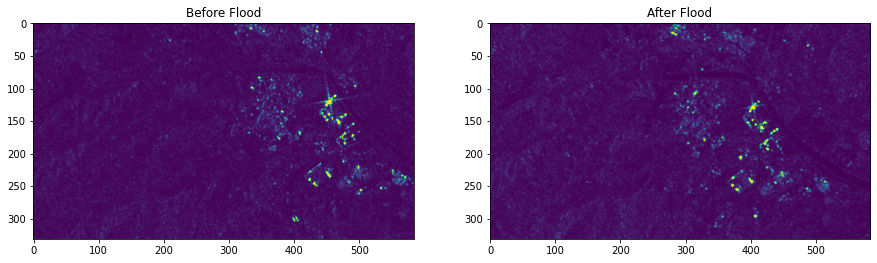

In [ ]:
evalscript = """
//VERSION=3

return [VH]
"""

# The VH band is used based on the publications mentioned above

request_pre = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL1_IW_ASC,
            time_interval= ("2020-01-01", "2020-01-10"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    size=size,
    config=config,
)

request_post = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL1_IW_ASC,
            time_interval=("2020-01-15", "2020-01-25"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    size=size,
    config=config,
)


sar_pre_flood = request_pre.get_data()[0]
sar_post_flood = request_post.get_data()[0]

fig, ax = plt.subplots(1, 2, figsize = (15, 15))
ax[0].imshow(sar_pre_flood)
ax[0].set_title("Before Flood")
ax[1].imshow(sar_post_flood)
ax[1].set_title("After Flood")
plt.show()

## Flood Estimation Using Change Detection 


In [ ]:
# Calculate change between pre and post flood values
change = sar_post_flood - sar_pre_flood

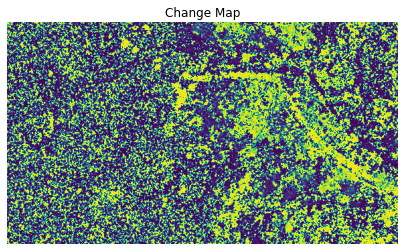

In [ ]:
plt.figure(figsize = (7, 7))
plt.imshow(abs(change))
plt.title("Change Map")
plt.axis("off")
plt.show()

In [ ]:
# calculate the Otsu-threshold
from skimage import filters
thresh = filters.threshold_otsu(change)

In [ ]:
# Fuzzify the raster values using the threshold
spread = change.flatten().std()
change_fuzzy = (1 + (change/thresh)**(-1*spread))**-1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Clustering the fuzzified change values with a Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, random_state=0).fit(change_fuzzy.reshape(-1, 1))


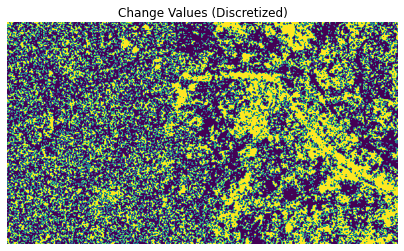

In [ ]:
# Discretizing change values based on cluster membership
change_discrete = gm.predict(change_fuzzy.reshape(-1, 1)).reshape(change_fuzzy.shape)
plt.figure(figsize=(7, 7))
plt.imshow(change_discrete)
plt.title("Change Values (Discretized)")
plt.axis("off")
plt.show()


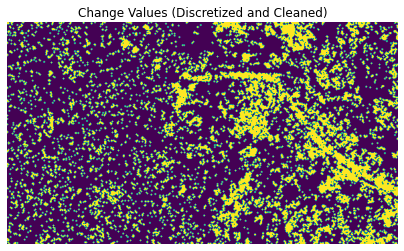

In [ ]:
# Cleaning of spurious pixels (by performing morphological opening)
from skimage.morphology import opening, disk

footprint = disk(1)                             # disk radius = 1
flood_mask = opening(change_discrete, footprint)
plt.figure(figsize=(7, 7))
plt.imshow(flood_mask)
plt.title("Change Values (Discretized and Cleaned)")
plt.axis("off")
plt.show()

## Calculating the area affected by the flood

In [ ]:
pixel_area = resolution**2
num_flood_pixels = change_discrete.sum()
total_area = num_flood_pixels*pixel_area
total_area_km2 = total_area/1e6
print(f"The total area affected by the flood in the region of interest is {total_area_km2} square Kms")

The total area affected by the flood in the region of interest is 8.1558 square Kms


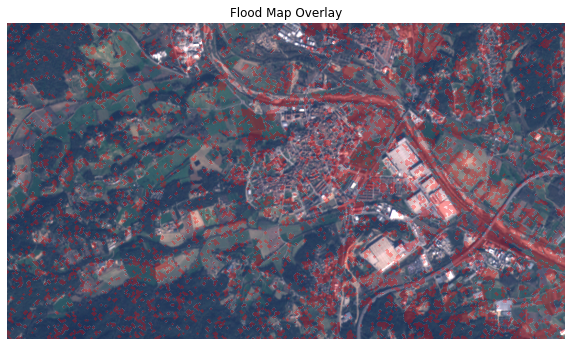

In [ ]:
# Overlay the flood-map on the image 
plt.figure(figsize = (10,10))
plt.imshow(np.clip(image_pre_true * 3.5/255, 0, 1))
cmap = colors.ListedColormap(['white', 'red'])
plt.imshow(flood_mask, cmap = cmap, alpha=0.3*(flood_mask>0))
plt.title("Flood Map Overlay")
plt.axis("off")
plt.show()


On visual inspection, this makes sense as most of the flooding is centred around the river Todera on the right side of the image. 